# Imports

In [1]:
from Code_Ring_Network import CodeRingNetwork
from utilities import bimodal_exponential_noise, exponential, bimodal_gaussian_noise, sigmoid

import numpy as np
from scipy.signal import find_peaks
from scipy.stats import weightedtau
import matplotlib.pyplot as plt
import os
%matplotlib inline
%cd experiments/

c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\experiments


# Redefine some plotting functions to be interactive

In [2]:
def plot_activity(self, ax: plt.axis,
                    ring_inputs: np.ndarray, v: np.ndarray = [], u: np.ndarray = [],
                    z: np.ndarray = [], I_prime: np.ndarray = []) -> None:
    '''
    Plots the time series of the variables involved with the ring layer.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param ring_inputs np.ndarray: "I"; the array of inputs into the ring layer
        ring_inputs determine the order of activation of the ring neurons
    :param v np.ndarray: the activation (v) series of each ring neuron
        If not being plotted, will be [].   
    :param u np.ndarray: the deactivation (u) series of each ring neuron
        If not being plotted, will be [].   
    :param z np.ndarray: the output (z) series of each ring neuron
        If not being plotted, will be [].   
    :param I_prime np.ndarray: the "effective input" (I') series of each ring neuron
        If not being plotted, will be [].   

    :returns: None
    '''
    # include 8 most active ring neurons in legend
    sorted_inputs = np.flip(np.argsort(ring_inputs.squeeze()))
    for i in sorted_inputs[:8]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'z_{i}', c=color, linestyle='solid')
    
    # add '_' to beginning of these labels in the legend so they're ignored
    # we want to ignore the later half of inputs for visual clarity so legend isn't too big
    for i in sorted_inputs[8:]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'_v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'_u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"_I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'_z_{i}', c=color, linestyle='solid')

    # ax.legend(loc='upper right')
    ax.set_ylim([-1, 1])
    ax.set_xlabel('t')
    ax.set_title('Variable Plots')
    lines = [plt.Line2D([0], [0], color='black', linewidth=1, linestyle=style) for style in ['dashed','dotted','dashdot','solid']]
    labels = ["v", "u", "r'","z"]
    plt.legend(lines, labels)
    plt.axhline(y=0.0, c="black", linewidth=0.05)

In [3]:
def plot_final_doodle(self, ax: plt.axis,
                        xs: np.array, ys: np.array,
                        intersec_pts: np.ndarray,
                        individualize_plot: bool = True, **plot_kwargs) -> None:
    '''
    Plots the final doodle.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param individualize_plot bool: whether the plot should be individualized to fit
        that specific doodle's range of outputs, include legend, etc. This should be 
        True for most cases, but False when using CodeRingNetwork.show_results().

    :returns: None
    '''
    # plot lines
    ax.plot(xs, ys, alpha=0.5, c='black')

    if individualize_plot:
        # plot final pen point
        ax.scatter(xs[-1], ys[-1], alpha=0.8, marker = 'o', c='black', label='Final Point')
        # organize plot
        ax.set_xlim([plot_kwargs['xmin'],plot_kwargs['xmax']])
        ax.set_xlabel('x', fontsize = 14)
        ax.set_ylim([plot_kwargs['ymin'],plot_kwargs['ymax']])
        ax.set_ylabel('y', fontsize = 14)
        ax.set_box_aspect(1)
        ax.set_title('Final Output')
        ax.legend()
        intersec_point_size = 20
        
    else:
        intersec_point_size = 4

    # plot all intersection points (if any)
    if intersec_pts.any():
        ax.scatter(intersec_pts[:,0], intersec_pts[:,1],
                    color='red', marker='o', s=intersec_point_size,
                    label='Intersections')


In [4]:
def plot_results(self, xs: np.array, ys: np.array, intersec_pts: np.ndarray,
                    ring_inputs: np.array, v: np.ndarray, u: np.ndarray,
                    z: np.ndarray, I_prime: np.ndarray,
                    folder_name: str,
                    epoch: int, iteration: int, active_idx: int, winner_idx: int,
                    score: float, plot_gif, idx_folders, **plot_kwargs) -> None:
    '''
    Plots the final resulting doodle and the variable activity graph of the ring layer. 
        The plots are saved to directory: `folder_name`\\`epoch` if plot_gif is True.
        Else, they're just saved in `folder_name`.
    
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param ring_inputs np.array: the array of inputs into the ring layer
    :param v np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of v (activation) values of the ring layer. 
        If not being plotted, will be [].    
    :param u np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of u (deactivation) values of the ring layer. 
        If not being plotted, will be [].        
    :param z np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of z (output) values of the ring layer. 
        If not being plotted, will be [].        
    :param I_prime np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of I_prime (resource) values of the ring layer. 
        If not being plotted, will be [].
    :param folder_name str: the model instance's corresponding folder name
    :param epoch int: the current epoch
    :param iteration int: the current iteration within the current epoch
    :param active_idx int: the index of the active map neuron
    :param winner_idx int: the index of the winner map neuron
    :param score float: the score of the outputted doodle
    :param plot_gif bool: whether to plot a GIF for each episode. This is used to determine the trial's folder structure
    :param idx_folders bool: whether each active map neuron's iterations should be kept in a separate folder or not.
        NOTE: this gives greater clarity in the way one neuron may learn over time.

    :returns: None
    '''
    f, axs = plt.subplots(1, 2)
    self.plot_final_doodle(axs[0], xs, ys, intersec_pts, **plot_kwargs)
    self.plot_activity(axs[1], ring_inputs, v, u, z, I_prime)

    f.suptitle(f'Epoch {epoch}, Iteration {iteration}\n\
                Score = {np.round(score,2)} | Active = {active_idx} | Winner = {winner_idx}',
                fontsize=12)
    f.tight_layout()
    
    if plot_gif:
        if not os.path.isdir(f'{folder_name}\\{epoch}'):
            os.makedirs(f'{folder_name}\\{epoch}')
        f.savefig(f'{folder_name}\\{epoch}\\plot_{self.id_string}_epoch{epoch}')
    elif idx_folders:
        if not os.path.isdir(f'{folder_name}\\neurons\\{active_idx}'):
            os.makedirs(f'{folder_name}\\neurons\\{active_idx}')
        f.savefig(f'{folder_name}\\neurons\\{active_idx}\\plot_{self.id_string}_idx{active_idx}_epoch{epoch}')
    else:
        if not os.path.isdir(f'{folder_name}\\plots'):
            os.makedirs(f'{folder_name}\\plots')
        f.savefig(f'{folder_name}\\plots\\plot_epoch{epoch}_iteration{iteration}_{self.id_string}')

    plt.show(f)


In [5]:
CodeRingNetwork.plot_activity = plot_activity
CodeRingNetwork.plot_final_doodle = plot_final_doodle
CodeRingNetwork.plot_results = plot_results

# Parameters & Definitions

In [6]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 700

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

In [7]:
crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-03-28 123000766742


# Metric

In [8]:
def nominal_ang_dev_metric(code_activity, **metric_kwargs):
    n = len(code_activity)
    active_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
    num_high = len(active_idxs)
    activity_order = np.flip(np.argsort(code_activity[active_idxs])) # decreasing order, because highest activity fires first
    effector_order = active_idxs[activity_order]
    delta_angle = 360 / n

    init_effector = effector_order[0]
    init_angle = init_effector * delta_angle

    # check if active zone wraps around past 0 deg. if so, break up chain into 2 parts before combining
    if init_angle + (num_high * delta_angle) > 350:
        # get how many steps in 1st part of chain
        steps_from_init_to_0 = (360 - init_angle) / delta_angle
        # get how many steps in 2nd part of chain
        steps_from_0_to_end = num_high - steps_from_init_to_0
        # then combine the two parts
        ideal_angles = np.concatenate((np.arange(init_angle, 360, step=delta_angle), 
                                    np.arange(0, (steps_from_0_to_end * delta_angle), step=delta_angle)))
    # else, active zone doesn't wrap around
    else:
        ideal_angles = np.arange(init_angle, (init_angle + (num_high * delta_angle)), step=delta_angle)

    effector_angles = effector_order * delta_angle
    devs = effector_angles - ideal_angles
    dev_sum = np.sum(np.abs(devs))
    print(dev_sum)
    score = exponential(dev_sum, rate=metric_kwargs['penalty_rate'], init_val=1)
    return score

In [9]:
def weighted_kendall_effectors(z_series, **metric_kwargs):
    peak_times = np.array([])

    for i in range(z_series.shape[0]):
        peak_time, peak_props = find_peaks(z_series[i,:], height=0.8)
        if peak_time.shape[0] == 1:
            peak_times = np.concatenate((peak_times, peak_time))
        elif peak_time.shape[0] == 0:
            peak_times = np.concatenate((peak_times, [999]))
        else: # more than 1 peak for effector i
            print(f'Multiple peaks for neuron {i}: {peak_time}')
            max_peak = np.argmax(peak_props['peak_heights'])
            peak_times = np.concatenate((peak_times, peak_time[max_peak]))

    print('peak_times', peak_times)

    n = z_series.shape[0]
    ideal = np.arange(1, n+1)
    # print('ideal', ideal)
    active_angles = np.argwhere(peak_times < 999).flatten() * 360 / n
    # print('active angles', active_angles)
    weighted_taus = []
    for i in range(n):
        ideal_rolled = np.roll(ideal, i)
        wtd_tau_normd = (weightedtau(peak_times, ideal_rolled, rank=False, weigher=lambda x: 1 if (x*360/n) in active_angles else 0, additive=True).statistic + 1) / 2
        weighted_taus += [wtd_tau_normd]
    
    best_w_tau = np.max(weighted_taus)
    print('best wtau idx: ',  np.argmax(weighted_taus))
    score = sigmoid(best_w_tau, beta=metric_kwargs['score_beta'], mu=metric_kwargs['score_mu'])
    print('score', score)
    print('best_w_tau', best_w_tau)

    return score

# Actual Testing Area

In [10]:
# score = 0.0
# while score < 0.01:
#     code_input = (np.concatenate(([0.99999], np.linspace(1, min_activity_value, noise_num_high), np.zeros(noise_num_low-1))))

#     r = np.random.randint(0, crn.ring_layer.num_ring_units)
#     code_input = np.roll(code_input, r)
#     # code_input = bimodal_gaussian_noise(num_low=noise_num_low, num_high=noise_num_high, 
#     #                                     mean_low=noise_mean_low, mean_high=noise_mean_high, 
#     #                                     sigma_low=noise_sigma_low, sigma_high=noise_sigma_high, 
#     #                                     shuffle=False, clip_01=True)
    
#     code_output = np.where(code_input >= min_activity_value, code_input, 0.0)

#     # determine output of code layer (input into ring layer)
#     ring_input = crn.code_layer.weights_to_ring_from_code @ code_output

#     # determine activity of duration layer
#     # TODO: right now, this is just a constant
#     dur_output = crn.duration_layer.activate(0.2)

#     # integrate ring layer model over time
#     v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)

#     # limit t_steps to end of integration
#     t_steps = z_series.shape[1]

#     # apply model results to the drawing system
#     x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

#     # evaluate drawing
#     # score, curvatures, intersec_pts, intersec_times = crn.evaluate(x_series, y_series, t_steps=t_steps, **metric_kwargs)
#     score = weighted_kendall_effectors(z_series, score_beta=score_beta, score_mu=score_mu)

#     plt.matshow(code_output.T.reshape(1,36),vmin=0,vmax=1)
#     plt.colorbar()
#     plt.title(f'score={score}')
#     plt.yticks([])

#     ## get points for peak of each effector's activity
#     # # get peaks of z spikes
#     # max_times = np.argmax(z_series, axis=1).flatten()
#     # peak_vals = z_series[np.arange(crn.ring_layer.num_ring_units),max_times]
#     # active_idxs = np.argwhere(peak_vals > 0.4).flatten()
#     # act_mdpt_times = max_times[active_idxs]
#     # mdpts = np.vstack((x_series[act_mdpt_times], y_series[act_mdpt_times])).T
#     midpts = np.empty(0) 

#     crn.plot_results(x_series, y_series, midpts, ring_input, v=[], u=[], z=z_series, I_prime=[], folder_name=crn.folder_name, epoch=-1, iteration=-1, active_idx=-1, winner_idx=-1, score=score)


# Effector Parameter Adjusting

In [11]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 7000

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)


ID string: 2024-03-28 123000870464


### Testing alpha (momentum)
Decision: change alpha to 0.5

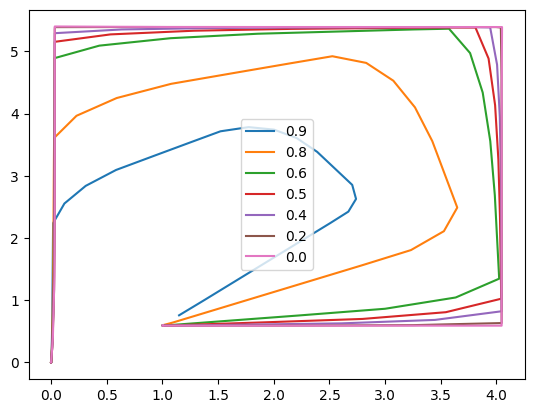

In [14]:
PLOT_MINMAX = 20
crn.ring_layer.alpha = 0.9
crn.ring_layer.psi = 1.2

# c1 - baseline parameters
c1 = np.zeros(crn.ring_layer.num_ring_units)
c1[[9,0,27,18]] = np.linspace(1,0.5,len([9,0,27,18]))
score = 0.0

# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.5], np.zeros(3))))

code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.8

# c2 - alpha=0.8
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.6

# c2 - alpha=0.7
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.5

# c2 - alpha=0.5
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.4

# c2 - alpha=0.4
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.2

# c2 - alpha=0.2
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.0

# c2 - alpha=0.0
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

plt.legend()

### Fix the shorter durations of later effectors
decision: increase psi (lateral inhibtion) to 2.0

In [13]:
crn.ring_layer.alpha = 0.5

crn.ring_layer.psi = 1.2 # 1.2. lateral inhibition in dvdt eqn
crn.ring_layer.phi = 1.2 # 0.5->1.2. resource depletion
crn.ring_layer.rho = 0.1 # rate of increase of u (proportional to z, r', d)
crn.ring_layer.lambda_ = 5 # gain on u-v term in dvdt eqn

PLOT_MINMAX = 50

# c1 - baseline parameters

# 12-sided polygon
# c1 = np.zeros(crn.ring_layer.num_ring_units)
# c1[np.arange(36)] = np.linspace(1,0.21,len(np.arange(36)))

c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.5], np.zeros(3)))) - 0.3

# c1 = bimodal_gaussian_noise(noise_num_low+4,noise_num_high-4,noise_mean_low,noise_mean_high,noise_sigma_low,noise_sigma_high, shuffle=False)
# print(np.sort(c1))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')
except TypeError:
    pass

crn.ring_layer.lambda_ = 10

# c2 - psi = 1.4
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass

crn.ring_layer.lambda_ = 15

# c2 - psi = 1.6
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass

crn.ring_layer.lambda_ = 20

# c2 - psi = 1.8
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass

crn.ring_layer.lambda_ = 25

# c2 - psi = 1.9
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass

crn.ring_layer.lambda_ = 30

# c2 - psi = 2
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
score = 0.0
while score < 0.1:
    # code_input = np.concatenate((np.linspace(1, min_activity_value+0.2, num_desired_high), np.zeros(crn.ring_layer.num_ring_units-num_desired_high)))
    # r = np.random.randint(0, crn.ring_layer.num_ring_units)
    # code_input = np.roll(code_input, r)
    # code_input = bimodal_exponential_noise(num_low=noise_num_low, 
    #                                     num_high=noise_num_high, 
    #                                     noise_rate_low=noise_rate_low,
    #                                     noise_rate_high=noise_rate_high,
    #                                     shuffle=False,
    #                                     clip_01=True)
    ideal = np.concatenate((np.linspace(0.2, 0.5, noise_num_high-4), np.zeros(noise_num_low), np.linspace(0.21, 0.9, 4)))
    random_roll = np.random.randint(0, crn.code_layer.num_code_units)
    flip_vector = 1 # np.random.randint(0,2)

    if flip_vector:
        code_input = np.flip(np.roll(ideal, random_roll))
    else:
        code_input = np.roll(ideal, random_roll)


    code_output = np.where(code_input >= min_activity_value, code_input, 0.0)
    
    # determine outp
    roll_val = np.random.randint(0, crn.code_layer.num_code_units)
    code_input = np.roll(code_input, roll_val)
    code_output = np.where(code_input >= min_activity_value, code_input, 0.0)

    score = nominal_ang_dev_metric(code_output, min_activity_value=min_activity_value, penalty_rate=-0.01)

    # print(code_output)

    # determine output of code layer (input into ring layer)
    ring_input = (crn.code_layer.weights_to_ring_from_code @ code_output).squeeze()
    print(np.round(ring_input, 3))
    print(np.round(score, 3))

    # determine activity of duration layer
    # TODO: right now, this is just a constant
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass


crn.ring_layer.lambda_ = 35

# c2 - psi = 3
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
try:
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, u_series, z_series, I_prime_series, '', 0, f'{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

    # plt.plot(x_series, y_series, label=f'{crn.ring_layer.lambda_}')
except TypeError:
    pass

plt.legend()

SyntaxError: expected 'except' or 'finally' block (2698017105.py, line 108)

# Effector Layer Studies

In [ ]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 700

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

In [ ]:
crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-03-26 220755519545


## Show robustness to noise (but no change in sequence)

### Trial 1

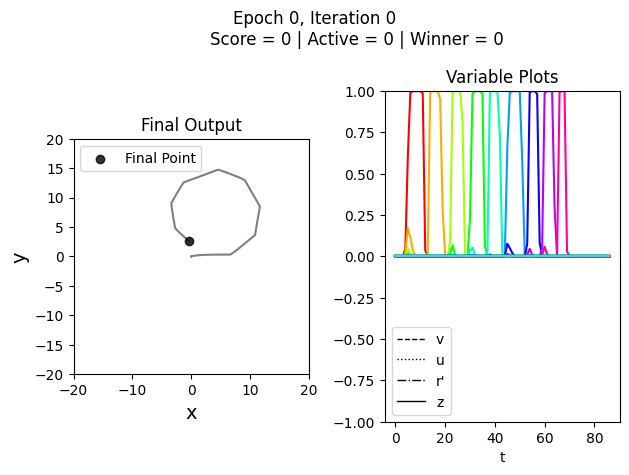

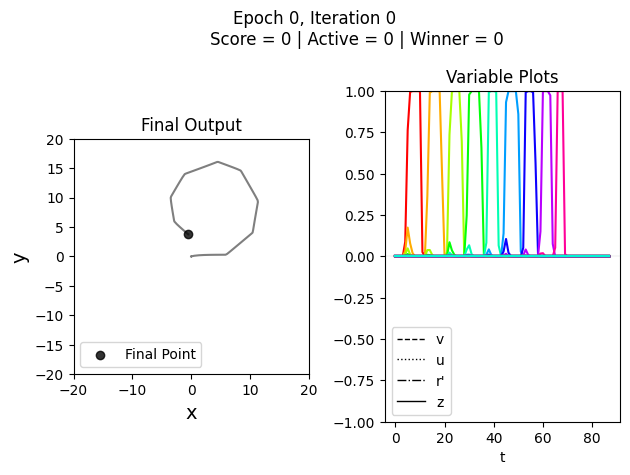

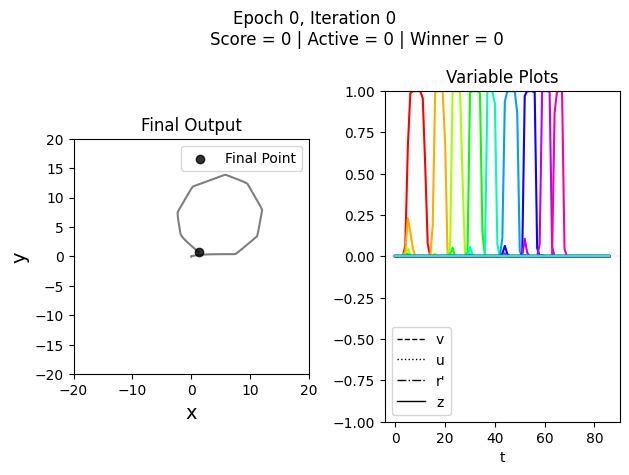

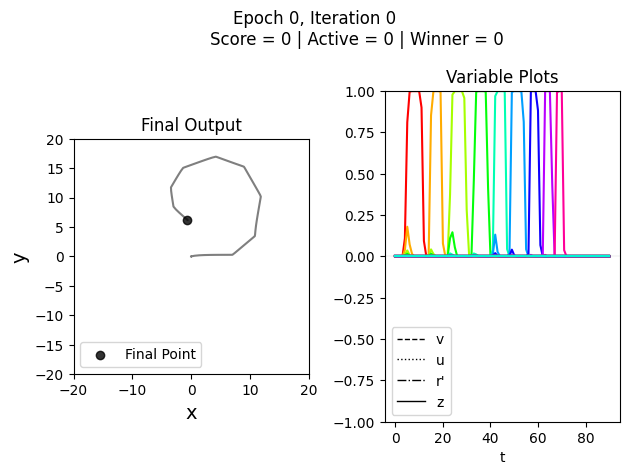

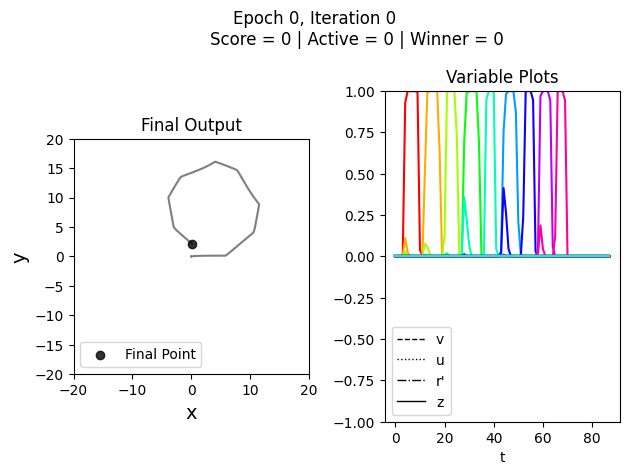

In [ ]:
PLOT_MINMAX = 20

# c1 - baseline
c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.5], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c2 - noise < 0.01
noise2 = 0.01
c2 = c1 + ((np.random.uniform(0, 2*noise2, size=crn.code_layer.num_code_units)-noise2)/2)
code_output = np.where(c2 >= min_activity_value, c2, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c3 - noise < 0.02
noise3 = 0.02
c3 = c1 + ((np.random.uniform(0, 2*noise3, size=crn.code_layer.num_code_units)-noise3)/2)
code_output = np.where(c3 >= min_activity_value, c3, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.04
noise4 = 0.04
c4 = c1 + ((np.random.uniform(0, 2*noise4, size=crn.code_layer.num_code_units)-noise4)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.1
noise5 = 0.05
c4 = c1 + ((np.random.uniform(0, 2*noise5, size=crn.code_layer.num_code_units)-noise5)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

### Trial 2

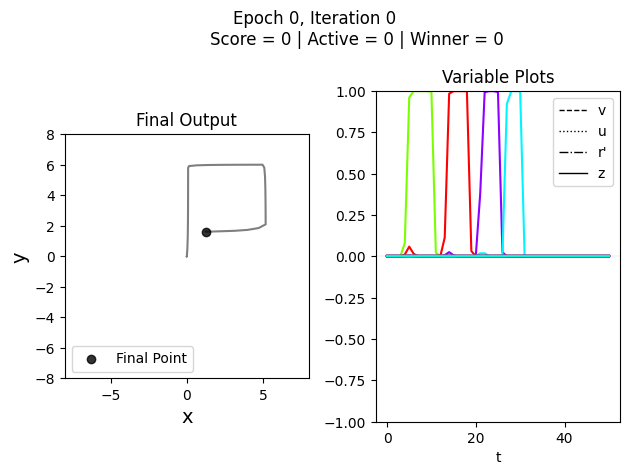

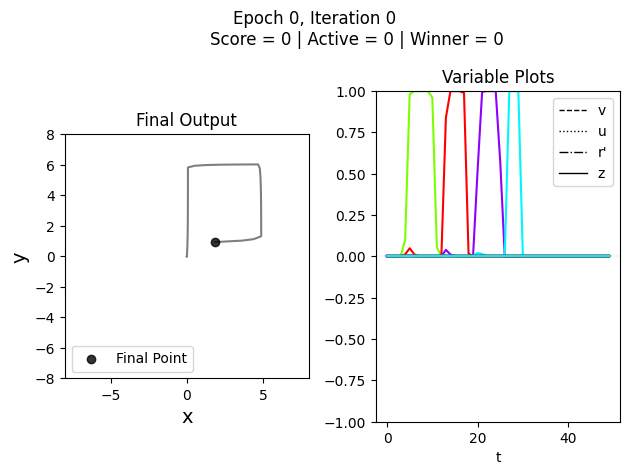

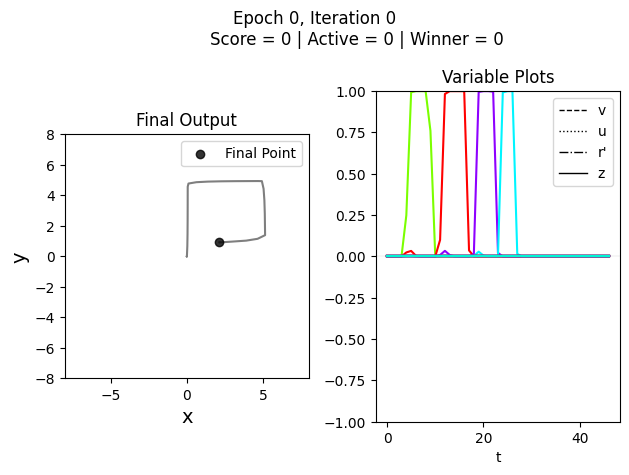

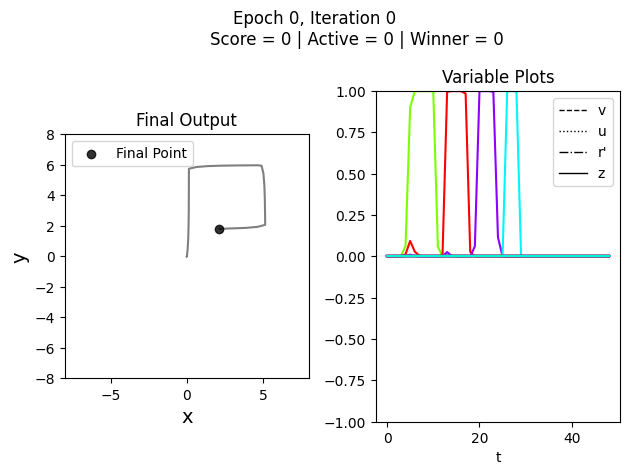

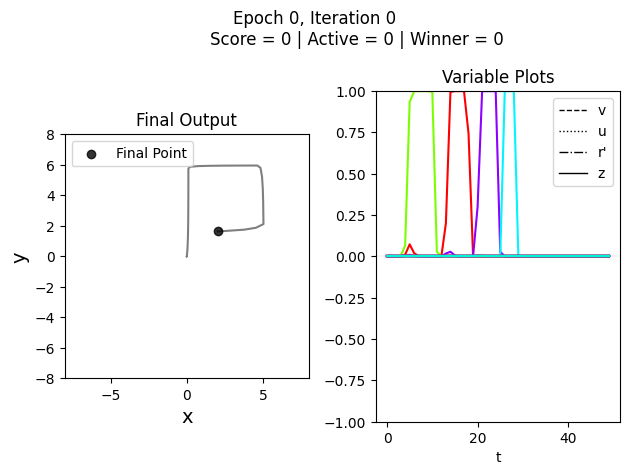

In [ ]:
PLOT_MINMAX = 8
# c1 - baseline
c1 = np.zeros(crn.ring_layer.num_ring_units)
c1[[9,0,27,18]] = [0.9, 0.8, 0.7, 0.6]
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c2 - noise < 0.01
noise2 = 0.01
c2 = c1 + ((np.random.uniform(0, 2*noise2, size=crn.code_layer.num_code_units)-noise2)/2)
code_output = np.where(c2 >= min_activity_value, c2, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c3 - noise < 0.02
noise3 = 0.02
c3 = c1 + ((np.random.uniform(0, 2*noise3, size=crn.code_layer.num_code_units)-noise3)/2)
code_output = np.where(c3 >= min_activity_value, c3, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.04
noise4 = 0.04
c4 = c1 + ((np.random.uniform(0, 2*noise4, size=crn.code_layer.num_code_units)-noise4)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.1
noise5 = 0.05
c4 = c1 + ((np.random.uniform(0, 2*noise5, size=crn.code_layer.num_code_units)-noise5)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

### Trial 3

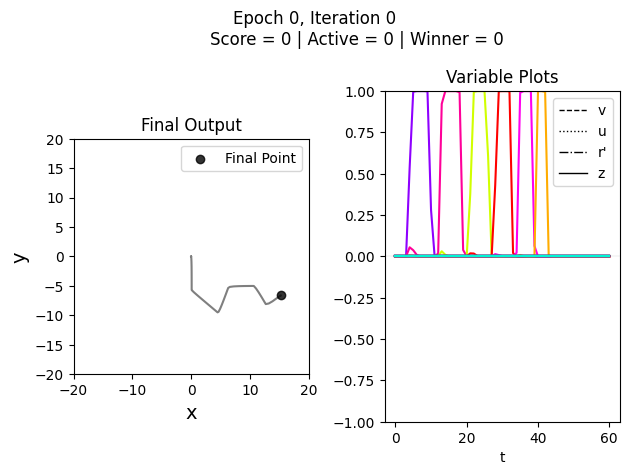

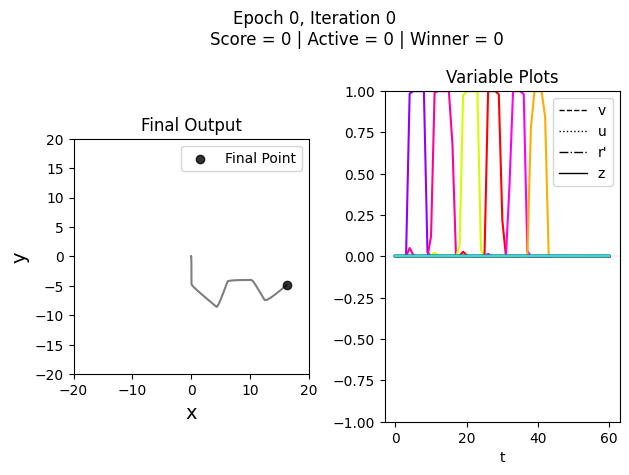

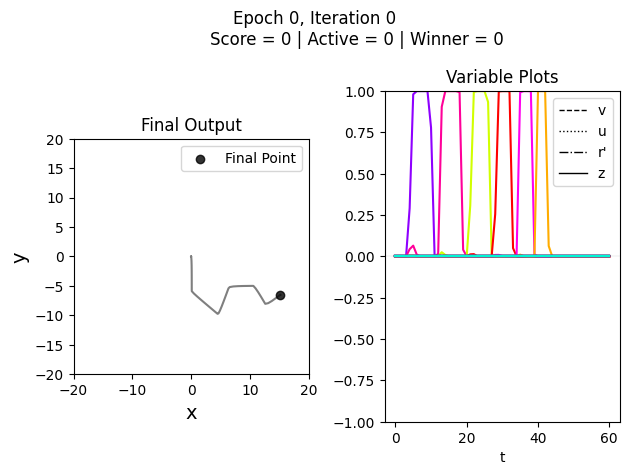

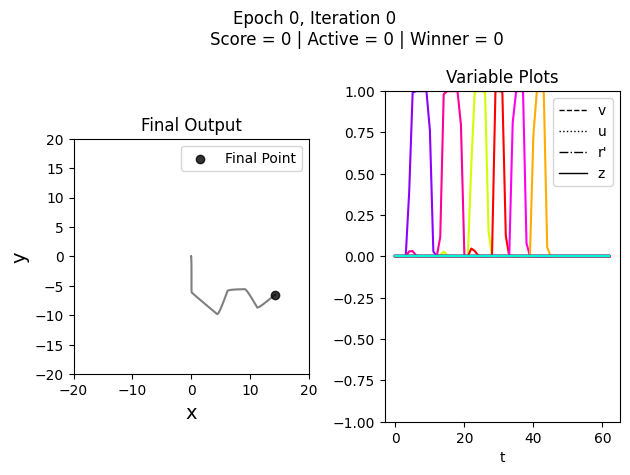

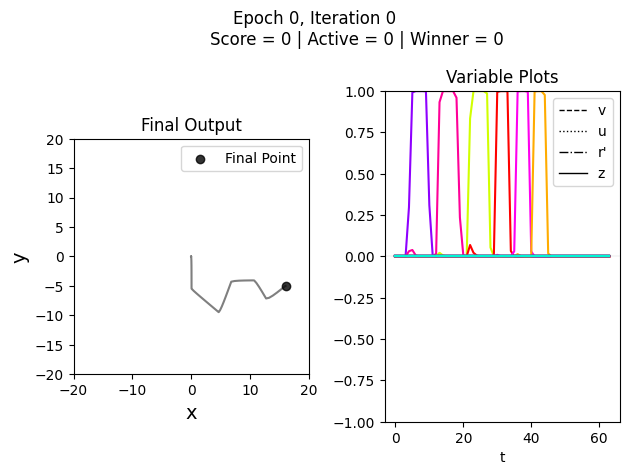

In [ ]:
PLOT_MINMAX = 20

# c1 - baseline
c1 = np.zeros(crn.ring_layer.num_ring_units)
c1[[27,32,7,0,30,4]] = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c2 - noise < 0.01
noise2 = 0.01
c2 = c1 + ((np.random.uniform(0, 2*noise2, size=crn.code_layer.num_code_units)-noise2)/2)
code_output = np.where(c2 >= min_activity_value, c2, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c3 - noise < 0.02
noise3 = 0.02
c3 = c1 + ((np.random.uniform(0, 2*noise3, size=crn.code_layer.num_code_units)-noise3)/2)
code_output = np.where(c3 >= min_activity_value, c3, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.04
noise4 = 0.04
c4 = c1 + ((np.random.uniform(0, 2*noise4, size=crn.code_layer.num_code_units)-noise4)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# c4 - noise < 0.1
noise5 = 0.05
c4 = c1 + ((np.random.uniform(0, 2*noise5, size=crn.code_layer.num_code_units)-noise5)/2)
code_output = np.where(c4 >= min_activity_value, c4, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

## Show sensitivity to changes in sequence

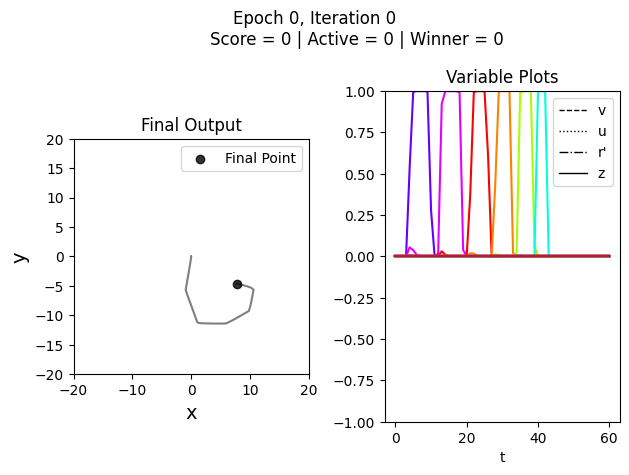

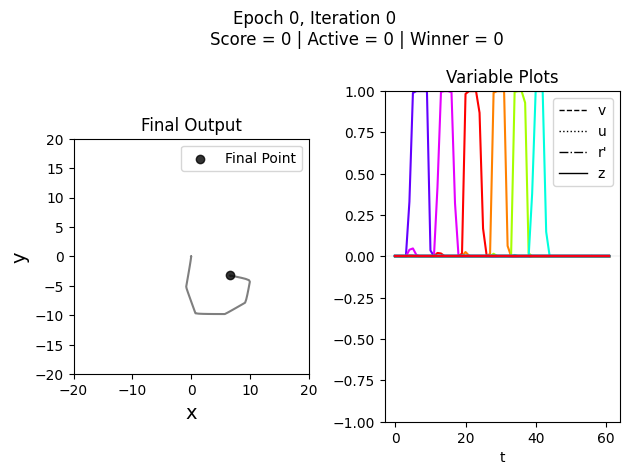

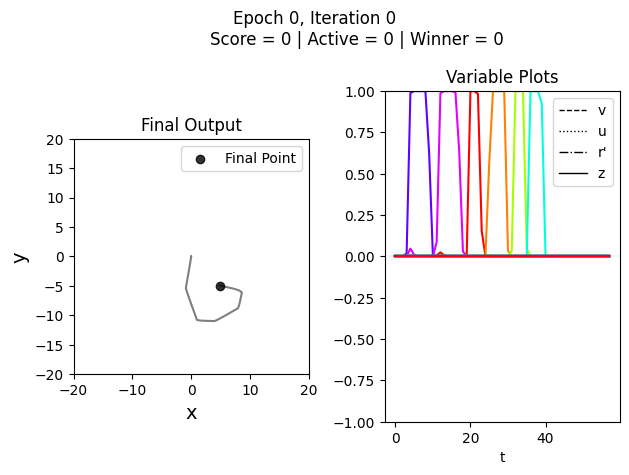

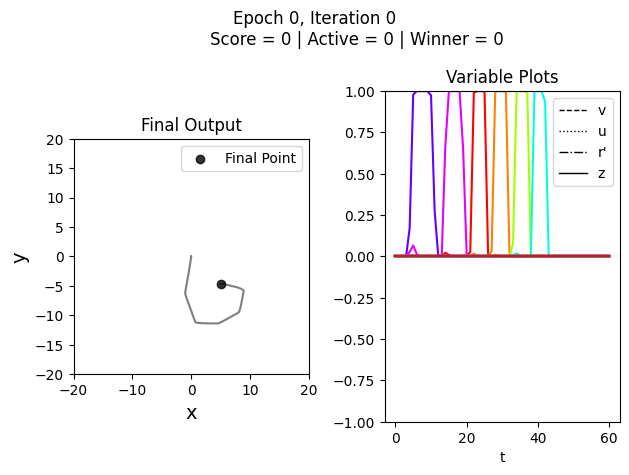

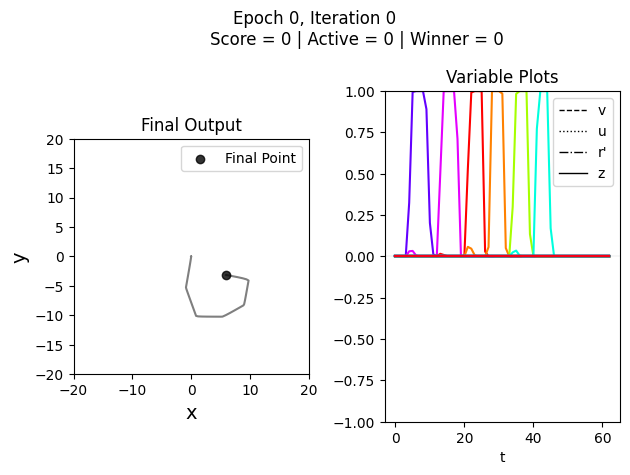

In [ ]:
# PLOT_MINMAX = 20

# # c1 - baseline
# c1 = np.zeros(crn.ring_layer.num_ring_units)
# c1[[26,29,0,3,8,17]] = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
# code_output = np.where(c1 >= min_activity_value, c1, 0.0)
# ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
# dur_output = crn.duration_layer.activate(durs)
# v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
# t_steps = z_series.shape[1]
# x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# # c2 - noise < 0.01
# noise2 = 0.01
# c2 = c1 + ((np.random.uniform(0, 2*noise2, size=crn.code_layer.num_code_units)-noise2)/2)
# code_output = np.where(c2 >= min_activity_value, c2, 0.0)
# ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
# dur_output = crn.duration_layer.activate(durs)
# v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
# t_steps = z_series.shape[1]
# x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# # c3 - noise < 0.02
# noise3 = 0.02
# c3 = c1 + ((np.random.uniform(0, 2*noise3, size=crn.code_layer.num_code_units)-noise3)/2)
# code_output = np.where(c3 >= min_activity_value, c3, 0.0)
# ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
# dur_output = crn.duration_layer.activate(durs)
# v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
# t_steps = z_series.shape[1]
# x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# # c4 - noise < 0.04
# noise4 = 0.04
# c4 = c1 + ((np.random.uniform(0, 2*noise4, size=crn.code_layer.num_code_units)-noise4)/2)
# code_output = np.where(c4 >= min_activity_value, c4, 0.0)
# ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
# dur_output = crn.duration_layer.activate(durs)
# v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
# t_steps = z_series.shape[1]
# x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

# # c4 - noise < 0.1
# noise5 = 0.05
# c4 = c1 + ((np.random.uniform(0, 2*noise5, size=crn.code_layer.num_code_units)-noise5)/2)
# code_output = np.where(c4 >= min_activity_value, c4, 0.0)
# ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
# dur_output = crn.duration_layer.activate(durs)
# v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
# t_steps = z_series.shape[1]
# x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

## Theoretical vs Transitional vs Actual Doodles

c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\Code_Ring_venv\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `event`.
  warn("The following arguments have no effect for a chosen solver: {}."


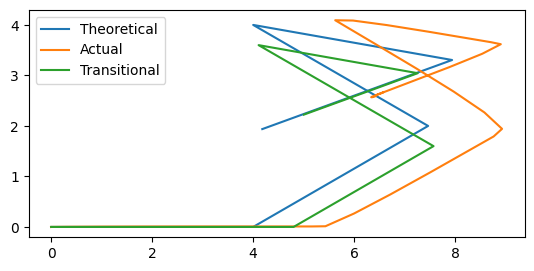

In [ ]:
def get_theoretical_doodle(code_activity, segment_lengths):
    x_segments = [0]
    y_segments = [0]
    for i in np.flip(np.argsort(code_activity)):
        if code_activity[i] >= min_activity_value:
            x, y = crn.ring_layer.headings[i]
            x_segments += [x * segment_lengths]
            y_segments += [y * segment_lengths]
    x_series = np.cumsum(x_segments)
    y_series = np.cumsum(y_segments)

    return (x_series, y_series)

c = np.zeros(36)
c[[0,3,15,35,20]] = np.linspace(1,0.21,len([0,3,15,35,20]))
xs_thr, ys_thr = get_theoretical_doodle(c, 4)
plt.plot(xs_thr, ys_thr, label='Theoretical')

code_output = np.where(c >= min_activity_value, c, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
plt.plot(x_series, y_series, label='Actual')

dom_idxs = np.argmax(z_series, axis=0)
# get transition times. anywhere the dominant index changes, but include endpoints too. 
# unique() in case the dominant idx changes at t=0 ot t_max
transition_times = np.unique(np.concatenate(([0], np.argwhere(np.diff(dom_idxs) != 0).flatten(), [z_series.shape[1]])))
xsegs_trns, ysegs_trns = [0], [0]
for t in range(z_series.shape[1]):
    dom_idx = dom_idxs[t]
    if z_series[dom_idx][t] > min_activity_value:
        xsegs_trns += [0.8*crn.ring_layer.headings[dom_idx,0]]
        ysegs_trns += [0.8*crn.ring_layer.headings[dom_idx,1]]

xs_trns = np.cumsum(xsegs_trns)
ys_trns = np.cumsum(ysegs_trns)
plt.plot(xs_trns, ys_trns, label='Transitional')
plt.legend()
plt.gca().set_aspect('equal')

# Determine Doodle Segment Lengths
Question: Is this inconsistent because of the integration method? Or due to model parameters?

Other issue: The length of doodle depends on the number of t_steps. Should each t_step be multiplied by dt?

48


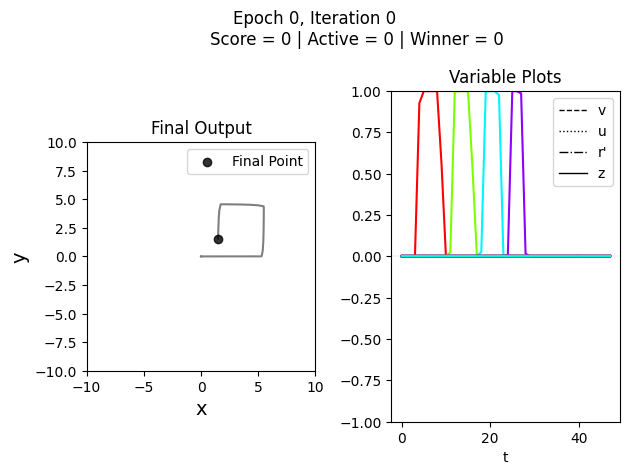

1.0: 16.476619781540915
48


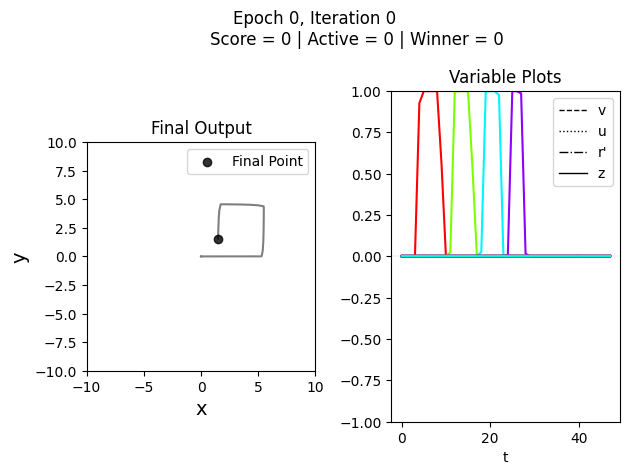

0.9233333333333333: 16.476619781540915
48


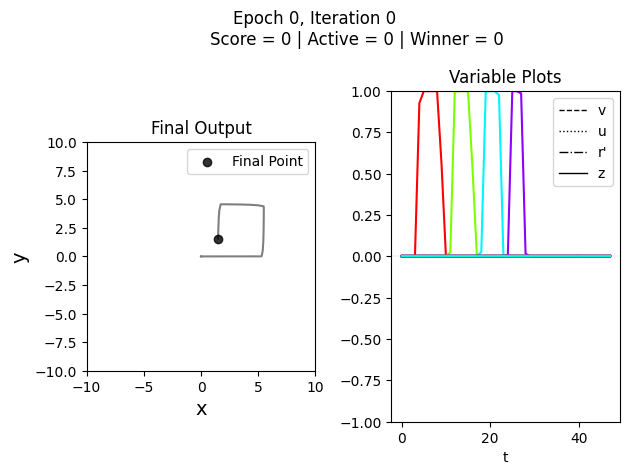

0.8466666666666667: 16.476619781540915
48


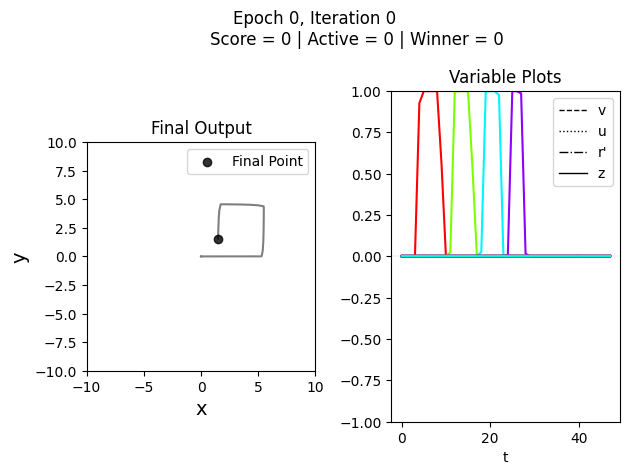

0.77: 16.476619781540915
48


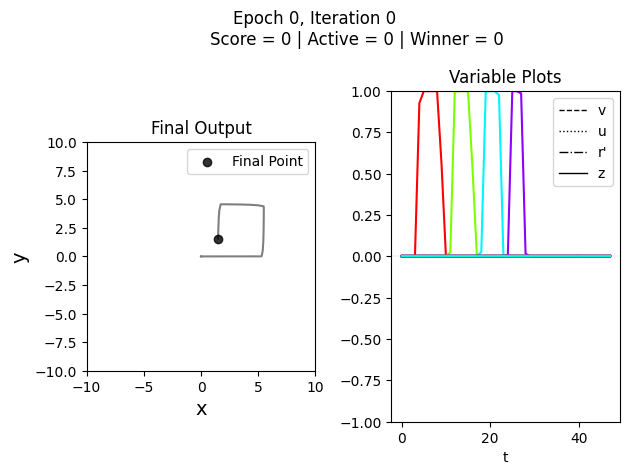

0.6933333333333334: 16.476619781540915
48


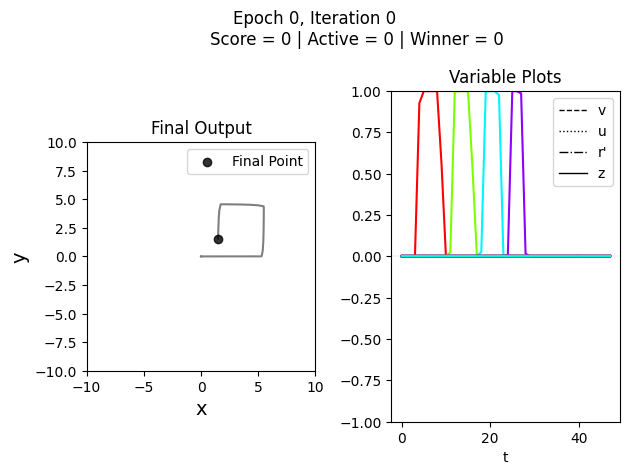

0.6166666666666667: 16.476619781540915
48


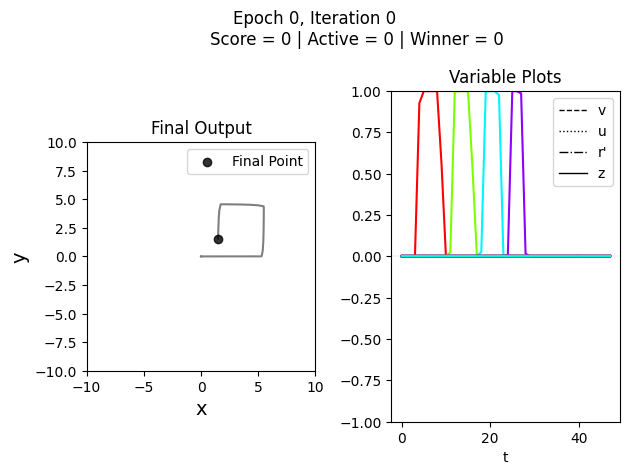

0.54: 16.476619781540915
48


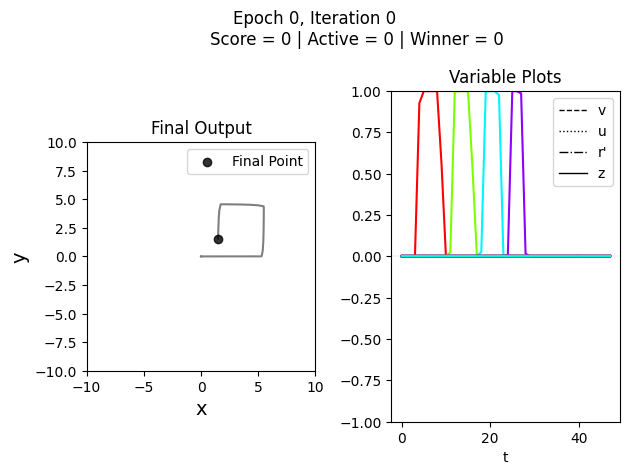

0.4633333333333334: 16.476619781540915
48


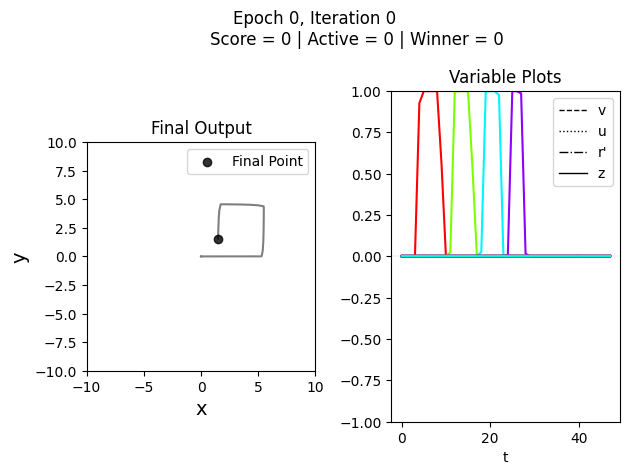

0.3866666666666667: 16.476619781540915
48


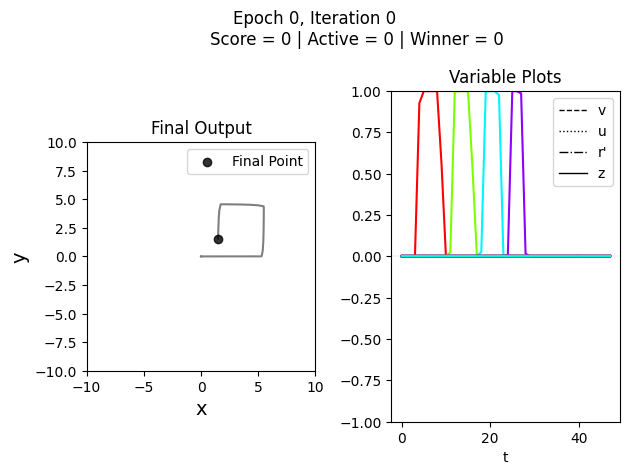

0.31: 16.476619781540915


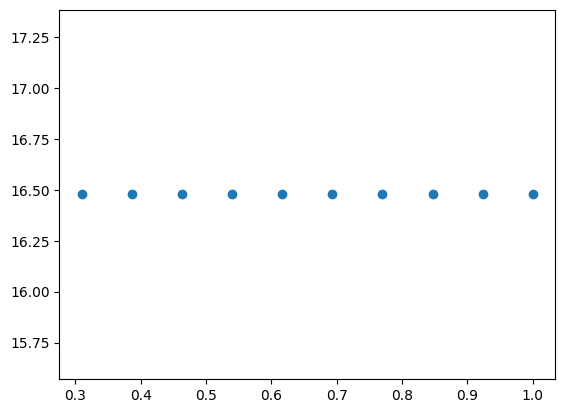

In [ ]:
PLOT_MINMAX = 10

crn.ring_layer.psi = 1.2
crn.ring_layer.phi = 1.2
crn.ring_layer.beta = 200
crn.ring_layer.gamma = 0.1
cvals = np.linspace(1,0.31,10)
lens = []
for cval in cvals:
    c1 = np.zeros(crn.ring_layer.num_ring_units)
    c1[[0,9,18,27]] = np.linspace(1,0.21,len([0,9,18,27]))
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    print(t_steps)
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)
    print(f'{cval}: {crn.calc_doodle_len(x_series, y_series)}')
    lens += [crn.calc_doodle_len(x_series, y_series)]
plt.scatter(cvals, lens)


